# Imports

In [1]:
import pandas as pd
import numpy as np
import torch

## File Paths

In [2]:
bert_emb_fp = "/home/vs428/project/Data/CC_BERT_188.csv"
cc_text_fp = "/home/vs428/project/Data/CC_text.csv"
data_fp = "/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/unq_pt_enc_clean_multilabel_nomismatches.pkl"

# Read in Data

## Read in BERT Embeddings

In [37]:
bert_emb = pd.read_csv(bert_emb_fp)

## Read in Data

In [3]:
data = pd.read_pickle(data_fp)

In [53]:
# create a multihot encoded vector for labels from multilabel
# dummies_df = pd.get_dummies(
#   data.join(pd.Series(data['multilabel'].apply(pd.Series).stack().reset_index(1, drop=True),
#                     name='multilabel1')).drop('multilabel', axis=1).rename(columns={'multilabel1': 'multilabel'}),
#   columns=['multilabel']).groupby('PAT_ENC_CSN_ID', as_index=False).sum()

We can't use pretrained BERT data since we can't match the IDs

# Train Doc2Vec and N-Gram models

## Read in CC Text

In [10]:
cc_text = pd.read_csv(cc_text_fp)

In [11]:
cc_text

,PAT_ENC_CSN_ID,PAT_ID,ADT_ARRIVAL_TIME,LINE,ENC_REASON_NAME,COMMENTS
0,84888672,Z3744421,2013-12-14 00:34:00.000,1.0,BURN,"pt states had a groin infection ? yeast, used ..."
1,85553809,Z3191382,2013-03-01 00:02:00.000,1.0,ABDOMINAL PAIN,abd pain x 2 days
2,85553853,Z3771693,2013-03-01 00:13:00.000,1.0,ABDOMINAL PAIN,ruptured appy seen at bridgeport hospital and ...
3,85553865,Z3950939,2013-03-01 00:16:00.000,1.0,DENTAL PAIN,Pt c/o left sided jaw pain (upper and lower) x...
4,85553894,Z1842336,2013-03-01 00:32:00.000,1.0,DYSMENORRHEA,onset of menses Monday; heavy flow; denies clo...
...,...,...,...,...,...,...
1884737,180569558,Z4762080,2018-10-19 23:45:00.000,1.0,SEIZURE- PRIOR HX OF,"pt acting normal today, sleeping with mom vomi..."
1884738,180569570,Z5813881,2018-10-19 23:47:00.000,1.0,HEAD LACERATION,"PT BIBEMS from UB, endorses something fell out..."
1884739,180569579,Z5813908,2018-10-19 23:49:00.000,1.0,ALCOHOL INTOXICATION,Pt presents to ED via EMS after being found pa...
1884740,180569580,Z5100298,2018-10-19 23:49:00.000,1.0,NECK PAIN,chronic neck pain with c/o right arm spasm. P...


In [41]:
cohort_cc_text = cc_text[
    cc_text["PAT_ENC_CSN_ID"].isin(data["PAT_ENC_CSN_ID"].unique())
]

## Develop embeddings

In [13]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer

### Develop embeddings for only CC Abd Pain Text

In [43]:
abd_pain_filters = [
    "ABDOMINAL PAIN",
    "FLANK PAIN",
    "EPIGASTRIC PAIN",
    "SIDE PAIN",
    "ABDOMINAL PAIN PREGNANT",
    "ABDOMINAL CRAMPING",
    "ABDOMINAL DISTENTION",
    "PELVIC PAIN",
    "PELVIC PAIN-PREGNANT",
]

In [46]:
abd_cc_text = cohort_cc_text[cohort_cc_text["ENC_REASON_NAME"].isin(abd_pain_filters)]

In [65]:
cvec = CountVectorizer(
    ngram_range=(1, 2), strip_accents="unicode", max_features=300, max_df=0.9
)

In [66]:
# abd_cc_text[abd_cc_text['LINE'] ==3]
# cc_text[cc_text['PAT_ID'] == "Z5397091"]
# abd_cc_text[abd_cc_text['PAT_ENC_CSN_ID'] == 93683957]

In [67]:
merged_abd_text = data.merge(
    abd_cc_text,
    on="PAT_ENC_CSN_ID",
    how="inner",
)

In [68]:
cvec.fit(merged_abd_text["COMMENTS"])

CountVectorizer(max_df=0.9, max_features=300, ngram_range=(1, 2),
                strip_accents='unicode')

In [69]:
ngrams = cvec.transform(merged_abd_text["COMMENTS"]).todense()

In [70]:
ngrams

matrix([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [71]:
cvec.vocabulary_

{'presents': 192,
 'abd': 1,
 'pain': 168,
 'associated': 27,
 'nausea': 142,
 'vomiting': 280,
 'since': 230,
 'denies': 54,
 'diarrhea': 64,
 'abd pain': 2,
 'nausea vomiting': 146,
 'denies diarrhea': 56,
 'for': 88,
 'eval': 78,
 'upper': 271,
 'onset': 162,
 'tonight': 265,
 'with': 292,
 'one': 161,
 'of': 156,
 'after': 7,
 'eating': 70,
 'states': 238,
 'has': 98,
 'had': 97,
 'in': 112,
 'past': 183,
 'pmd': 188,
 'and': 14,
 'for eval': 90,
 'upper abd': 272,
 'after eating': 8,
 'has had': 100,
 'left': 126,
 'blood': 34,
 'emesis': 73,
 'per': 186,
 'mother': 141,
 'blood in': 35,
 'patient': 184,
 'that': 251,
 'started': 236,
 'sunday': 247,
 'night': 147,
 'morning': 140,
 'worsening': 296,
 'seen': 218,
 'by': 40,
 'at': 28,
 'time': 259,
 'today': 263,
 'no': 148,
 'fever': 82,
 'patient with': 185,
 'pain that': 180,
 'that started': 252,
 'no vomiting': 152,
 'no fever': 150,
 'abdominal': 4,
 'abdominal pain': 5,
 'pain with': 182,
 'pt': 193,
 'approx': 21,
 'unabl

In [72]:
# Now do gensim doc2vec

In [73]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [74]:
documents = [TaggedDocument(doc, [i]) for i, doc in merged_abd_text["COMMENTS"].items()]

In [171]:
N = 250
model = Doc2Vec(documents, vector_size=N, window=2, min_count=1, workers=4)

Evaluate the doc2vec model

In [172]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
pca = PCA(n_components=2)

In [174]:
# pca.fit_transform()
x = np.zeros((len(documents), N))
for key in model.dv.index_to_key:
    x[key, :] = model.dv[key]

In [175]:
pca_transformed = pca.fit_transform(x)

In [176]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(np.unique(merged_abd_text["ENC_REASON_NAME"]))
# print (np.unique(y))
# ['c' 'mediumpurple']

# Mapping the colors to numbers
dics = {k: v for v, k in enumerate(sorted(set(merged_abd_text["ENC_REASON_NAME"])))}
y_mapped = [dics[x] for x in merged_abd_text["ENC_REASON_NAME"].tolist()]
# print (y_mapped)
# [0, 1, 1, 0, 0]

In [177]:
dics

{'ABDOMINAL CRAMPING': 0,
 'ABDOMINAL DISTENTION': 1,
 'ABDOMINAL PAIN': 2,
 'ABDOMINAL PAIN PREGNANT': 3,
 'EPIGASTRIC PAIN': 4,
 'FLANK PAIN': 5,
 'PELVIC PAIN': 6,
 'PELVIC PAIN-PREGNANT': 7,
 'SIDE PAIN': 8}

/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

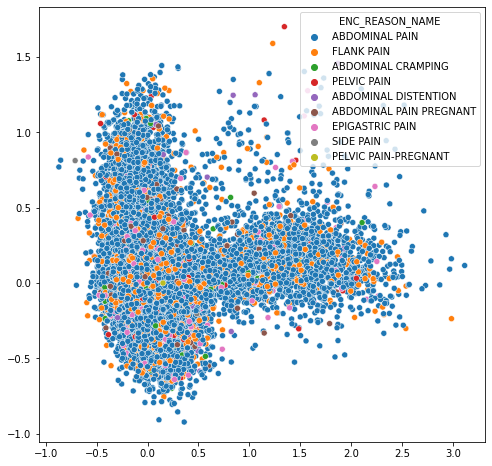

In [178]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
sns.scatterplot(
    pca_transformed[:, 0], pca_transformed[:, 1], hue=merged_abd_text["ENC_REASON_NAME"]
)

### Integrate it back into the dataset

In [212]:
abd_docvecs = pd.DataFrame(x)
abd_docvecs["PAT_ENC_CSN_ID"] = merged_abd_text["PAT_ENC_CSN_ID"]
abd_docvecs["ENC_REASON_NAME"] = merged_abd_text["ENC_REASON_NAME"]

In [213]:
abd_docvecs.columns = [f"doc2vec_{x}" for x in abd_docvecs.columns[:-2]] + [
    "PAT_ENC_CSN_ID",
    "ENC_REASON_NAME",
]

In [214]:
abd_docvecs

,doc2vec_0,doc2vec_1,doc2vec_2,doc2vec_3,doc2vec_4,doc2vec_5,doc2vec_6,doc2vec_7,doc2vec_8,doc2vec_9,...,doc2vec_242,doc2vec_243,doc2vec_244,doc2vec_245,doc2vec_246,doc2vec_247,doc2vec_248,doc2vec_249,PAT_ENC_CSN_ID,ENC_REASON_NAME
0,0.004501,0.008155,-0.001022,-0.050736,0.033137,-0.007950,0.001187,-0.005903,0.038737,0.078531,...,0.046810,-0.020525,-0.001815,0.014983,-0.027456,0.020408,0.044500,0.033763,92193999,ABDOMINAL PAIN
1,-0.039872,-0.018089,0.012394,0.047971,-0.001888,-0.016598,0.009476,0.026114,0.024592,-0.008585,...,0.080467,-0.031775,0.026329,0.051625,-0.080398,0.046983,0.024312,0.011038,92899329,ABDOMINAL PAIN
2,0.041197,0.056862,-0.062146,0.007518,-0.025059,-0.029079,0.009722,0.042312,0.036390,0.005574,...,0.006096,-0.056582,-0.026670,0.025353,0.024422,0.012641,0.010752,-0.023461,93008535,ABDOMINAL PAIN
3,-0.080527,0.055613,0.000255,-0.034888,-0.005026,-0.016730,0.027539,0.018249,0.074471,0.033461,...,0.015989,-0.067172,-0.000571,0.056108,-0.037593,0.129672,0.065499,-0.017217,93020623,ABDOMINAL PAIN
4,0.030630,-0.009631,0.025772,-0.021694,-0.017082,-0.003432,0.024249,0.012341,0.048135,0.003600,...,0.026596,0.002280,0.007052,-0.007350,-0.019183,0.016870,0.039110,0.023397,93207822,ABDOMINAL PAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69196,-0.071627,0.060178,-0.010689,-0.075472,0.100549,0.011447,0.111293,0.001202,0.021280,-0.020675,...,-0.004513,0.011276,-0.029239,0.114637,-0.016221,0.081263,0.029248,-0.072620,180567656,ABDOMINAL PAIN
69197,0.013737,0.015276,0.004859,0.009662,-0.028947,-0.039849,-0.008679,0.025324,0.043176,-0.010453,...,0.035443,-0.033724,0.018775,0.011650,0.007813,0.026637,0.034566,0.008655,180567822,ABDOMINAL PAIN
69198,-0.040915,-0.030561,-0.054930,0.002766,-0.046131,-0.059992,0.032212,-0.030298,0.042724,-0.078010,...,-0.025724,-0.038391,0.052133,0.031777,-0.046541,0.052721,0.020917,-0.023390,180568110,ABDOMINAL PAIN
69199,0.018239,0.077305,-0.116438,-0.042883,-0.014011,0.102628,-0.036265,0.016698,0.045037,0.022771,...,0.008061,-0.052117,0.043890,0.009316,0.034943,0.051672,0.038825,-0.061523,180568359,ABDOMINAL PAIN


In [216]:
cols = list(abd_docvecs.columns)
cols = cols[-2:] + cols[:-2]
abd_docvecs = abd_docvecs[cols]

,PAT_ENC_CSN_ID,doc2vec_0,doc2vec_1,doc2vec_2,doc2vec_3,doc2vec_4,doc2vec_5,doc2vec_6,doc2vec_7,doc2vec_8,...,doc2vec_240,doc2vec_241,doc2vec_242,doc2vec_243,doc2vec_244,doc2vec_245,doc2vec_246,doc2vec_247,doc2vec_248,doc2vec_249
0,92193999,0.004501,0.008155,-0.001022,-0.050736,0.033137,-0.007950,0.001187,-0.005903,0.038737,...,-0.024908,0.041403,0.046810,-0.020525,-0.001815,0.014983,-0.027456,0.020408,0.044500,0.033763
1,92899329,-0.039872,-0.018089,0.012394,0.047971,-0.001888,-0.016598,0.009476,0.026114,0.024592,...,0.037278,-0.036211,0.080467,-0.031775,0.026329,0.051625,-0.080398,0.046983,0.024312,0.011038
2,93008535,0.041197,0.056862,-0.062146,0.007518,-0.025059,-0.029079,0.009722,0.042312,0.036390,...,-0.055781,-0.029178,0.006096,-0.056582,-0.026670,0.025353,0.024422,0.012641,0.010752,-0.023461
3,93020623,-0.080527,0.055613,0.000255,-0.034888,-0.005026,-0.016730,0.027539,0.018249,0.074471,...,-0.045490,0.029534,0.015989,-0.067172,-0.000571,0.056108,-0.037593,0.129672,0.065499,-0.017217
4,93207822,0.030630,-0.009631,0.025772,-0.021694,-0.017082,-0.003432,0.024249,0.012341,0.048135,...,-0.027273,0.024049,0.026596,0.002280,0.007052,-0.007350,-0.019183,0.016870,0.039110,0.023397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69196,180567656,-0.071627,0.060178,-0.010689,-0.075472,0.100549,0.011447,0.111293,0.001202,0.021280,...,-0.127547,0.074524,-0.004513,0.011276,-0.029239,0.114637,-0.016221,0.081263,0.029248,-0.072620
69197,180567822,0.013737,0.015276,0.004859,0.009662,-0.028947,-0.039849,-0.008679,0.025324,0.043176,...,-0.009030,0.000650,0.035443,-0.033724,0.018775,0.011650,0.007813,0.026637,0.034566,0.008655
69198,180568110,-0.040915,-0.030561,-0.054930,0.002766,-0.046131,-0.059992,0.032212,-0.030298,0.042724,...,0.012460,0.048310,-0.025724,-0.038391,0.052133,0.031777,-0.046541,0.052721,0.020917,-0.023390
69199,180568359,0.018239,0.077305,-0.116438,-0.042883,-0.014011,0.102628,-0.036265,0.016698,0.045037,...,-0.019273,-0.036944,0.008061,-0.052117,0.043890,0.009316,0.034943,0.051672,0.038825,-0.061523


In [218]:
abd_docvecs.to_csv(
    "/home/vs428/project/Data/text_embeddings/CC_Emb_Abdpain_Only.csv", index=False
)

In [233]:
data_aug_dvs = data.merge(
    abd_docvecs.iloc[:, [0] + list(range(2, len(abd_docvec.columns) + 1))],
    on="PAT_ENC_CSN_ID",
    how="left",
)

In [235]:
data_aug_dvs[~data_aug_dvs["doc2vec_245"].isna()]

,PAT_ENC_CSN_ID,person_id,visit_occurrence_id,age,EdDisposition_AMA,EdDisposition_Admit,EdDisposition_Discharge,EdDisposition_Eloped,EdDisposition_Expired,EdDisposition_LWBS after Triage,...,doc2vec_240,doc2vec_241,doc2vec_242,doc2vec_243,doc2vec_244,doc2vec_245,doc2vec_246,doc2vec_247,doc2vec_248,doc2vec_249
1,92193999,12894663,12743657,50.0,NaN,1.0,NaN,NaN,NaN,NaN,...,-0.024908,0.041403,0.046810,-0.020525,-0.001815,0.014983,-0.027456,0.020408,0.044500,0.033763
5,92899329,37670962,13898205,59.0,NaN,NaN,1.0,NaN,NaN,NaN,...,0.037278,-0.036211,0.080467,-0.031775,0.026329,0.051625,-0.080398,0.046983,0.024312,0.011038
6,93008535,10853101,14472354,12.0,NaN,NaN,1.0,NaN,NaN,NaN,...,-0.055781,-0.029178,0.006096,-0.056582,-0.026670,0.025353,0.024422,0.012641,0.010752,-0.023461
9,93020623,11096654,13846975,12.0,NaN,NaN,1.0,NaN,NaN,NaN,...,-0.045490,0.029534,0.015989,-0.067172,-0.000571,0.056108,-0.037593,0.129672,0.065499,-0.017217
12,93207822,14050039,14300855,91.0,NaN,1.0,NaN,NaN,NaN,NaN,...,-0.027273,0.024049,0.026596,0.002280,0.007052,-0.007350,-0.019183,0.016870,0.039110,0.023397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85653,180567656,13032454,114529089,59.0,NaN,1.0,NaN,NaN,NaN,NaN,...,-0.127547,0.074524,-0.004513,0.011276,-0.029239,0.114637,-0.016221,0.081263,0.029248,-0.072620
85656,180567822,34429111,114497593,37.0,NaN,NaN,1.0,NaN,NaN,NaN,...,-0.009030,0.000650,0.035443,-0.033724,0.018775,0.011650,0.007813,0.026637,0.034566,0.008655
85658,180568110,29063569,114544215,72.0,NaN,NaN,1.0,NaN,NaN,NaN,...,0.012460,0.048310,-0.025724,-0.038391,0.052133,0.031777,-0.046541,0.052721,0.020917,-0.023390
85660,180568359,17635799,114557194,54.0,NaN,1.0,NaN,NaN,NaN,NaN,...,-0.019273,-0.036944,0.008061,-0.052117,0.043890,0.009316,0.034943,0.051672,0.038825,-0.061523


In [237]:
data_aug_dvs.to_pickle(
    "/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/unq_pt_enc_clean_multilabel_nomis_dvemb.pkl"
)

### Develop embeddings for all text in visit